In [1]:
# kadai 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
np.random.seed(0)  # set the random seed for reproducibility

In [4]:
def generate_sample(xmin, xmax, sample_size):
    x = np.linspace(start=xmin, stop=xmax, num=sample_size)
    pix = np.pi * x
    target = np.sin(pix) / pix + 0.1 * x
    noise = 0.05 * np.random.normal(loc=0., scale=1., size=sample_size)
    return x, target + noise


def calc_design_matrix(x, c, h):
    return np.exp(-(x[None] - c[:, None]) ** 2 / (2 * h ** 2))


# create sample
sample_size = 50
xmin, xmax = -3, 3
x, y = generate_sample(xmin=xmin, xmax=xmax, sample_size=sample_size)

In [5]:
# k-fold cross-validation
best_l, best_h = None, None
error = 100000000

for cur_l in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    for cur_h in [0.1, 1, 10, 100]:
        
        tmp_error = 0
        
        # split in 5
        for i in range(10):
            x_test = x[5*i:5*(i+1)]
            y_test = y[5*i:5*(i+1)]
            
            x_sample = np.concatenate([x[:5*i], x[5*(i+1):]])
            y_sample = np.concatenate([y[:5*i], y[5*(i+1):]])
            
            
            k = calc_design_matrix(x_sample, x_sample, cur_h)
            theta = np.linalg.solve(
                k.T.dot(k) + cur_l * np.identity(len(k)),
                k.T.dot(y_sample[:, None]))
            
            K = calc_design_matrix(x_sample, x_test, cur_h)
            prediction = np.ravel(K.dot(theta))
            
            for j in range(5):
                tmp_error += (prediction[j] - y_test[j])**2
                
        print('(l, h, tmp_error): ({}, {}, {})'.format(cur_l, cur_h, tmp_error))
                
                
        if tmp_error < error:
            best_l, best_h = cur_l, cur_h 
            error = tmp_error

(l, h, tmp_error): (1e-05, 0.1, 6.829444037934343)
(l, h, tmp_error): (1e-05, 1, 0.28266409973236445)
(l, h, tmp_error): (1e-05, 10, 8.785066122498504)
(l, h, tmp_error): (1e-05, 100, 8.280715616852483)
(l, h, tmp_error): (0.0001, 0.1, 6.829815720744827)
(l, h, tmp_error): (0.0001, 1, 0.26871432097664577)
(l, h, tmp_error): (0.0001, 10, 7.788724108450335)
(l, h, tmp_error): (0.0001, 100, 8.340445659709431)
(l, h, tmp_error): (0.001, 0.1, 6.833497638770422)
(l, h, tmp_error): (0.001, 1, 0.3235087600060603)
(l, h, tmp_error): (0.001, 10, 7.953382951081358)
(l, h, tmp_error): (0.001, 100, 8.992764744697546)
(l, h, tmp_error): (0.01, 0.1, 6.867302361890678)
(l, h, tmp_error): (0.01, 1, 0.7798379762088875)
(l, h, tmp_error): (0.01, 10, 8.254180963967915)
(l, h, tmp_error): (0.01, 100, 9.26705923410567)
(l, h, tmp_error): (0.1, 0.1, 7.079199302024457)
(l, h, tmp_error): (0.1, 1, 1.82501562629772)
(l, h, tmp_error): (0.1, 10, 8.272530798670369)
(l, h, tmp_error): (0.1, 100, 9.301789271722768)

In [6]:
print('Best (l, h): ({}, {})'.format(best_l, best_h))

Best (l, h): (0.0001, 1)


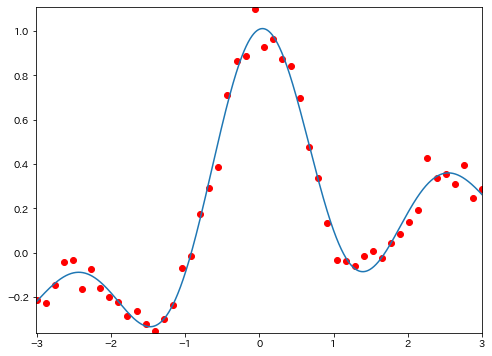

In [7]:
#
# visualization
#

# calculate design matrix
k = calc_design_matrix(x, x, best_h)

# solve the least square problem
theta = np.linalg.solve(
    k.T.dot(k) + best_l * np.identity(len(k)),
    k.T.dot(y[:, None]))

# create data to visualize the prediction
X = np.linspace(start=xmin, stop=xmax, num=5000)
K = calc_design_matrix(x, X, best_h)
prediction = K.dot(theta)

plt.figure(figsize=(8, 6))
plt.clf()
plt.scatter(x, y, c='red', marker='o')
plt.plot(X, prediction)

In [8]:
# kadai 2

<Figure size 432x288 with 0 Axes>

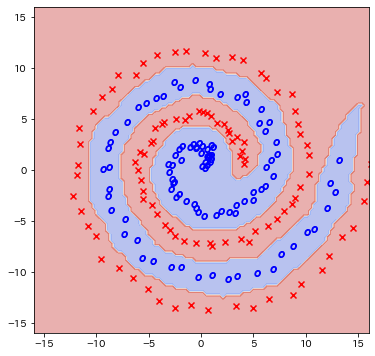

In [9]:
np.random.seed(1)


def generate_data(sample_size):
    a = np.linspace(0, 4 * np.pi, num=sample_size // 2)
    x = np.concatenate(
        [np.stack([a * np.cos(a), a * np.sin(a)], axis=1),
         np.stack([(a + np.pi) * np.cos(a), (a + np.pi) * np.sin(a)], axis=1)])
    x += np.random.random(size=x.shape)
    y = np.concatenate([np.ones(sample_size // 2), -np.ones(sample_size // 2)])
    return x, y


def build_design_mat(x1, x2, bandwidth):
    return np.exp(
        -np.sum((x1[:, None] - x2[None]) ** 2, axis=-1) / (2 * bandwidth ** 2))


def optimize_param(design_mat, y, regularizer, lr): #lr: learning rate
    theta = np.array([0.0 for i in range(200)])

    epoch = 0
    while epoch < 10000:
    
        i = 0
        for p in np.dot(design_mat, theta) * y:
            
            if 1 - p <= 0:
                theta -= lr * (2 * regularizer * theta)
            else:
                theta -= lr * ((y * design_mat)[i] + 2 * regularizer * theta)
                
            i += 1 
    
        epoch += 1
        
        
                
    return theta
    

def visualize(theta, x, y, grid_size=100, x_min=-16, x_max=16):
    grid = np.linspace(x_min, x_max, grid_size)
    X, Y = np.meshgrid(grid, grid)
    mesh_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
    design_mat = build_design_mat(x, mesh_grid, bandwidth=1.)
    plt.clf()
    plt.figure(figsize=(6, 6))
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)
    plt.contourf(X, Y, np.reshape(np.sign(design_mat.T.dot(theta)),
                                  (grid_size, grid_size)),
                 alpha=.4, cmap=plt.cm.coolwarm)
    plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], marker='$O$', c='blue')
    plt.scatter(x[y == -1][:, 0], x[y == -1][:, 1], marker='x', c='red')


x, y = generate_data(sample_size=200)
design_mat = build_design_mat(x, x, bandwidth=1.)
theta = optimize_param(design_mat, y, regularizer=1, lr=0.0001)

visualize(theta, x, y)